In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

In [4]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [5]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [13]:
from mlflow.tracking import MlflowClient
import mlflow
def get_model_run_id(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            return model_version_info.run_id
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

In [14]:
import mlflow
models = {}
run_ids = {}
stage = 'Staging'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    run_ids[mode] = get_model_run_id(model_name, stage)
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [9]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

SS1


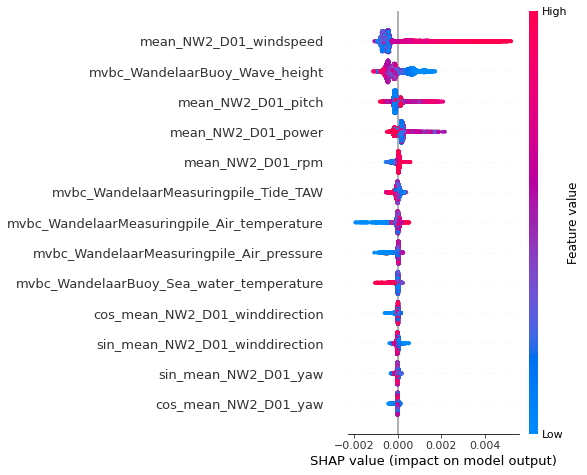

SS2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


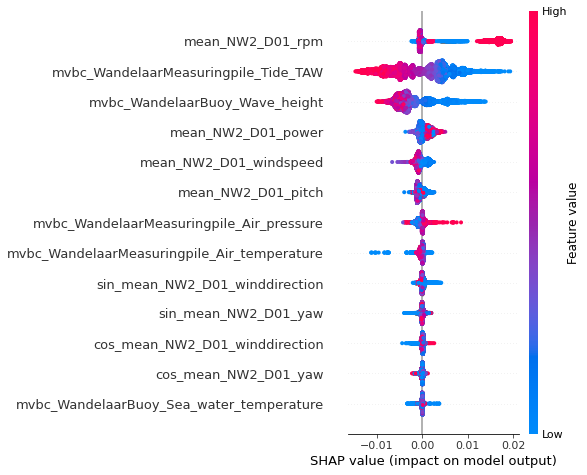

FA1


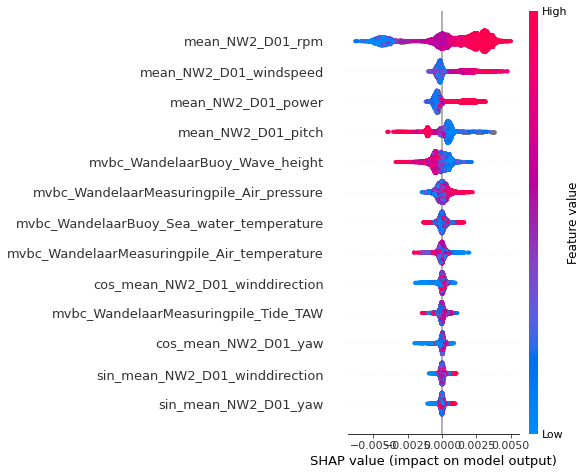

FA2


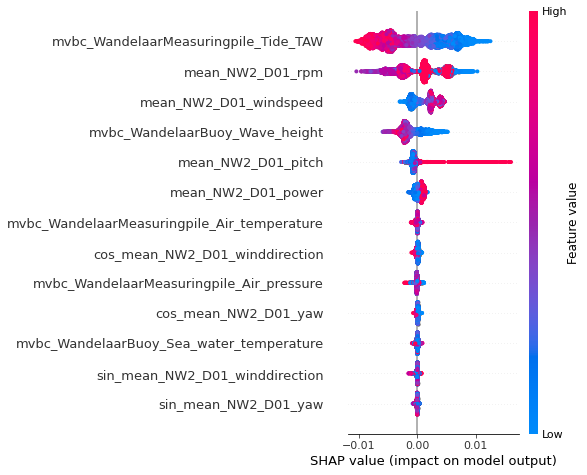

In [12]:
import mlflow
import shap

images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                location,
                "shap",
                "removed_harmonics"
            ])

for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]['regressor']
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(models[mode]['preprocessing_angles'].transform(inputs))

    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    shap.summary_plot(shap_value, models[mode]['preprocessing_angles'].transform(inputs), show=False)

    plt.gcf().axes[-1].set_aspect('auto')
    plt.tight_layout()
    plt.gcf().axes[-1].set_box_aspect(50)
    fig = plt.gcf()
    fig.savefig(fig_local_path)
    plt.show()
    plt.close()

In [15]:
for mode in tracked_frequencies.columns:
    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    run_id = rund_ids[mode]
    print(run_id)
    with mlflow.start_run(run_id):
        mlflow.log_artifacts(
            fig_local_path,
            'figures')
    mlflow.end_run()
    print('figure_uploaded')

NameError: name 'rund_ids' is not defined